<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Bottleneck-for-Decision-Trees" data-toc-modified-id="Information-Bottleneck-for-Decision-Trees-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Bottleneck for Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Proposal" data-toc-modified-id="Proposal-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Proposal</a></span></li><li><span><a href="#Implementation-of-the-algorithm" data-toc-modified-id="Implementation-of-the-algorithm-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation of the algorithm</a></span></li><li><span><a href="#IB-Tree-estimator-properties:-consitency-and-bias" data-toc-modified-id="IB-Tree-estimator-properties:-consitency-and-bias-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>IB Tree estimator properties: consitency and bias</a></span></li><li><span><a href="#Generalization:-IB-and-VC-dimension" data-toc-modified-id="Generalization:-IB-and-VC-dimension-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Generalization: IB and VC dimension</a></span></li></ul></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Toy-data-sets" data-toc-modified-id="Toy-data-sets-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Toy data sets</a></span></li><li><span><a href="#Optimal-split" data-toc-modified-id="Optimal-split-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Optimal split</a></span><ul class="toc-item"><li><span><a href="#Loss:-entropy" data-toc-modified-id="Loss:-entropy-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Loss: entropy</a></span></li><li><span><a href="#Loss:-Categorical-Information-Bottleneck" data-toc-modified-id="Loss:-Categorical-Information-Bottleneck-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Loss: Categorical Information Bottleneck</a></span></li></ul></li><li><span><a href="#Tree" data-toc-modified-id="Tree-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tree</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Circle-regularized-with-IB,-$\beta=0.1$" data-toc-modified-id="Circle-regularized-with-IB,-$\beta=0.1$-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Circle regularized with IB, $\beta=0.1$</a></span></li><li><span><a href="#Circle,-regularized-with-max_depth=20" data-toc-modified-id="Circle,-regularized-with-max_depth=20-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Circle, regularized with <code>max_depth=20</code></a></span></li><li><span><a href="#Circle,-regularized-with-min_n" data-toc-modified-id="Circle,-regularized-with-min_n-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Circle, regularized with <code>min_n</code></a></span></li><li><span><a href="#Easy-data" data-toc-modified-id="Easy-data-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>Easy data</a></span></li><li><span><a href="#Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N" data-toc-modified-id="Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N-2.4.5"><span class="toc-item-num">2.4.5&nbsp;&nbsp;</span>Evaluate Probability to end up in a leave with leave size N</a></span></li></ul></li><li><span><a href="#Impact-of-noise,-add-random-projections" data-toc-modified-id="Impact-of-noise,-add-random-projections-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Impact of noise, add random projections</a></span></li><li><span><a href="#Utils" data-toc-modified-id="Utils-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Utils</a></span></li></ul></li><li><span><a href="#Presentation" data-toc-modified-id="Presentation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Presentation</a></span></li></ul></div>

# Information Bottleneck for Decision Trees

## Proposal
Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. From an information theoretical perspective, they can be viewed as algorithms to construct optimal binary encodings $e: \mathcal{X} \mapsto \mathcal{B} $ for $\mathcal{B}$ being the set of binary words, and $\mathcal{X}$ being data sampled of an unkown distribution $P_X : \mathcal{X} \mapsto [0, 1]$.
It is interesting to analyze this in the information bottleneck framework (IB), which gives a justification to expect generalization.

Specifically, the following questions shall be answered:
- can we use decision trees to efficiently optimize for the IB objective? What is the time and space complexity of such an implementation?
- for which distributions $P_{X,Y}$ or probability densities $p_{X,Y}$ does this lead to a consistent unbiased estimator and for which distributions does it lead to a suboptimal estimator?
- What is the VC dimension of this algorithm? Can we find generalization bounds?
- How does this algorithm perform on different toy and real world datasets in comparison to other decision trees? How does a gradient boosted ensemble of these decision trees perform on a real world dataset, compared to a regular xgboost model?
- In the original IB paper, the authors propose the The information bottleneck iterative algorithm. How does it compare to IB trees?

## Implementation of the algorithm

The IB objective is given as
$$ J'(e) = \beta I(X, e(X)) - I(e(X), y)  = \beta ( H(X) - H(X|e(X) ) - H(y) + H(y|e(X)) $$
If we ignore all terms independent of $e$, we get:
$$ J(e) =  H(y|e(X)) - \beta H(X|e(X)) $$

It is straight forward to apply the IB method to decision trees. The first term  $H(y|e(X))$ is a widely used objective in decision trees, and the second term $\beta H(X|e(X))$ serves as a regularizer. 

In the fitting phase, the IB tree tries to find a binary split $f(x) = x_i > t$ such that $J(f)$ is minimal. If the optimal split is a constant function over the samples, all points are grouped into the same split and the (sub)tree is a leaf. In this way, pruning is no longer necessary.

The loss function for a non-leaf tree can be expressed as:


$$  J = H(y|e(X)) - \beta H(X|e(X)) $$
$$ = \sum_{i=0}^1 ( P(e(X)=i) * (H(y|e(X)=i) - \beta H(X|e(X)=i)) ) $$
$$ = P(e(X)=0) * J(left) + P(e(X)=1) * J(right) $$

The loss of a leaf is simply:

$$    J = H(y|e(X)) - \beta H(X|e(X)) $$
$$      = H(y) - \beta H(X) $$

To estimate $H(X)$, we simply assume a uniform distribution over all samples, i.e. $log(N)$.

This allows an efficient recursive computation of the loss.



## IB Tree estimator properties: consitency and bias
Notes:
- This is definitely not in general a consistent estimator: examples where the algorithm fails to converge to a good solution is given in the experimental section (caro data).
- This estimator also has a bias, since it can only express decision boundaries of the type ${x : \bigwedge\limits_{i=1}^{depth} x_i = t_i$} $ (see experiments) - it cannot accurately represent a circle and favors squared shapes in the absence of sufficient samples
- An interesting subclass of distributions are those that can be expressed perfectly by a decision tree of limited size
    - even there, the greedy optimization may get stuck in local optima (caro data problem)
    - but good news is that for most distrubitions that can be expressed, the caro data problem does not occur

## Generalization: IB and VC dimension
An upper bound for the VC dimension of a decision tree is $2^{#leaves}$.
- Given $N, \beta$, what is the VC dimension of an IB tree? Can we find an upper bound for $I(X, e(X)) \leq \psi(D)$?
- What is the implied generalization bound?

# Implementation

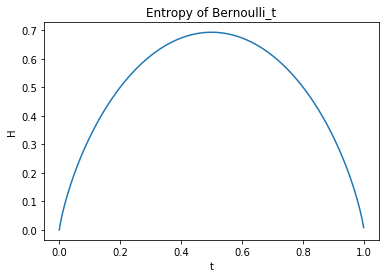

In [3]:
from scipy.special import xlogy
import numpy as np
from matplotlib import pyplot as plt
import seaborn


def entropy(y):
    """Return the empirical entropy of samples y of 
    a categorical distribution

    Arguments:
        y: np.array (N, C) , categorical labels
    Returns:
        H: float
    """
    if len(y) == 0:
        return 0
    py = y.mean(0)
    h = -np.sum(xlogy(py, py))
    return h


def plot_entropy_of_bernoulli():
    p = []
    h = []
    for t in range(1000):
        p += [t/1000]
        y = np.zeros((1000, 2))
        y[:t, 0] = 1
        y[t:, 1] = 1
        h += [entropy(y)]

    plt.plot(p, h)
    plt.xlabel("t")
    plt.ylabel("H")
    plt.title("Entropy of Bernoulli_t")
    plt.show()


plot_entropy_of_bernoulli()

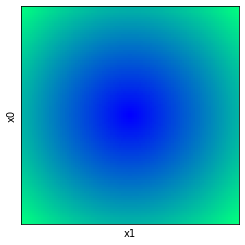

In [73]:
def grid2d(N):
    """
    Create an (N*N, 2) matrix of samples on a grid of [0,1]x[0,1]
    """
    X = np.zeros(((N)*(N), 2))
    X[:, 0] = np.repeat(np.arange(0, 1, 1/N), N)
    X[:, 1] = np.concatenate([np.arange(0, 1, 1/N)]*N)
    return X-X.mean(0)


X = grid2d(100)
y = np.linalg.norm(X, axis=1)


def plot_on_grid(y, N, show=True):
    plt.imshow(y.reshape((N, N)), cmap='winter', interpolation='nearest')
    plt.xlabel("x1")
    plt.ylabel("x0")
    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    if show:
        plt.show()


plot_on_grid(y, 100)

## Toy data sets

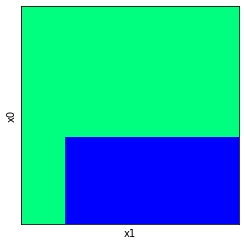

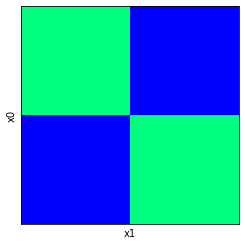

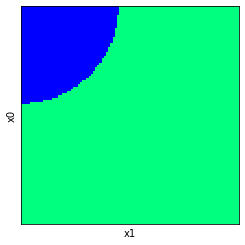

(array([[-0.495, -0.495],
        [-0.495, -0.485],
        [-0.495, -0.475],
        ...,
        [ 0.495,  0.475],
        [ 0.495,  0.485],
        [ 0.495,  0.495]]), array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [74]:
def easy_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[X[:, 0] < 0.1, 0] = 1
    y[X[:, 1] < -0.3, 0] = 1
    y[:, 1] = 1 - y.sum(1)
    plot_on_grid(y[:, 0], 100)
    return X, y


easy_data()


def caro_data():
    X = grid2d(20)
    y = np.zeros((20*20, 2))
    y[(X[:, 0] < 0) == (X[:, 1] < 0), 0] = 1
    y[:, 1] = 1 - y.sum(1)
    plot_on_grid(y[:, 0], 20)
    return X, y


caro_data()

def circle_y(X):
    y = np.zeros((10000, 2))
    y[np.square(X+0.5).sum(1) > 0.2, 0] = 1
    y[:, 1] = 1 - y.sum(1)
    return y
    
def circle_data():
    X = grid2d(100)
    y = circle_y(X)
    plot_on_grid(y[:, 0], 100)
    return X, y


circle_data()

## Optimal split

In [77]:
def smooth(y, window=None, mode='valid'):
    window = window or min(max(len(y)//30, 2), 20)
    return np.convolve(np.ones(window)/window, y, mode=mode)

In [81]:
import pdb

def optimal_split_plot(X, y, J):
    plt.figure(figsize=(5, 5))
    c = plt.rcParams['axes.prop_cycle'].by_key()['color']
    N, d = X.shape
    Y = y
    for i in range(d):
        x = X[:, i]
        sort = np.argsort(x)
        x, y_i = x[sort], y[sort]
        best_loss = np.inf
        best_split_idx = 0
        h = []
        eval_treshhold = np.unique(x)
        print(f"X{i}")
        for t in eval_treshhold:
            # evaluate loss for splitting [:s], [s:]
            y_l = y_i[x <= t]
            y_r = y_i[x > t]
#             print(y_l.sum(0), y_r.sum(0),"|",end='')
#             if i==1:
#                 pdb.set_trace()
            s = len(y_l)
            loss = J(y_l)*s/N + J(y_r)*(N-s)/N
            h.append(loss)

        plt.plot(eval_treshhold, h, label=i, color=c[i])

    plt.xlabel("Threshhold")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Loss: entropy

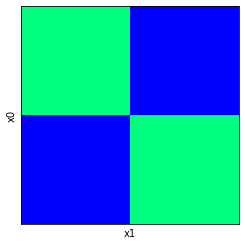

X0
X1


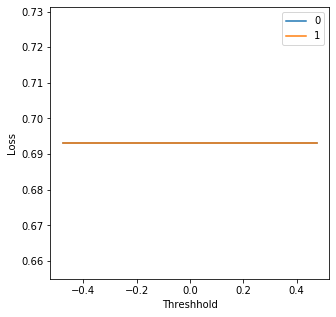

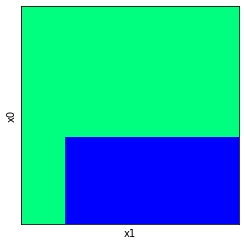

X0
X1


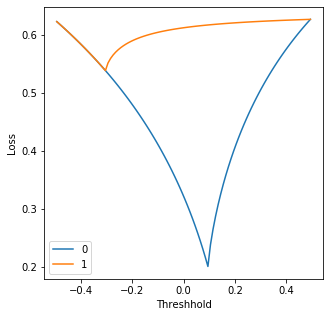

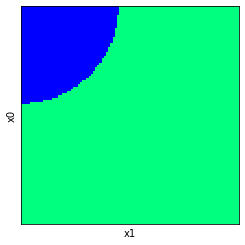

X0
X1


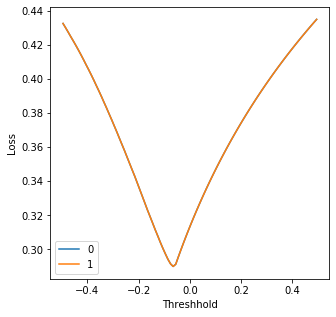

In [82]:
X, y = caro_data()
optimal_split_plot(X, 1-y, entropy)

X, y = easy_data()
optimal_split_plot(X, y, entropy)

X, y = circle_data()
optimal_split_plot(X, y, entropy)

### Loss: Categorical Information Bottleneck

In [45]:
def categorical_IB(beta):
    def J(y):
        if len(y) == 0:
            return 0
        return entropy(y) - beta*np.log(len(y))
    return J

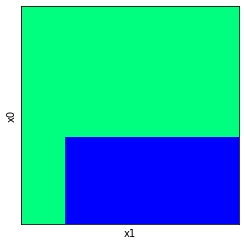

X0
X1


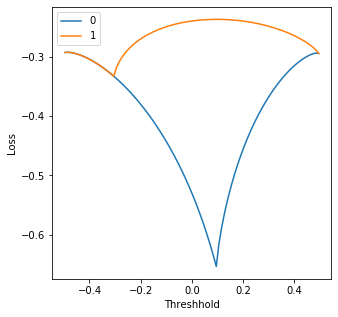

X0
X1


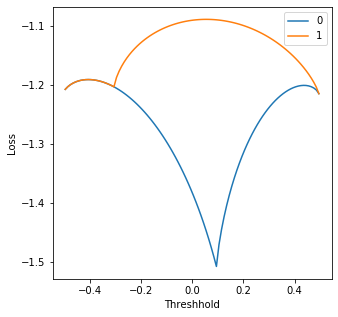

X0
X1


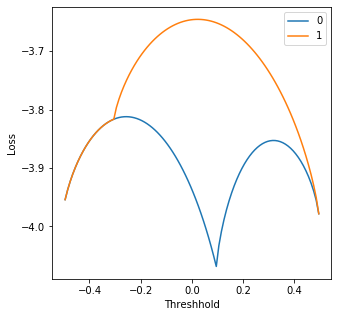

In [83]:
X, y = easy_data()
optimal_split_plot(X, y, categorical_IB(0.1))
optimal_split_plot(X, y, categorical_IB(0.2))
optimal_split_plot(X, y, categorical_IB(0.5))

## Tree

In [84]:
import pdb
def debug(f):
    def debugged(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except Exception as e:
            print(type(e), e)
            pdb.set_trace()
            f(*args, **kwargs)
    return debugged

def differential_entropy(y):
    pass

def optimal_t_from_selection(x, y, ts, J, min_n):
    """
    Time complexity:
    O(T*N)
    Space complexity:
    O(N+T) - to store the input
    """
    N = len(x)
    best_loss = np.inf
    best_t = -np.inf
    idx = None
    for t in ts: # O(T)
        # evaluate loss for splitting [:s], [s:]
        y_l = y[x < t] # O(N)
        y_r = y[x > t] # O(N)
        s = len(y_l)
        loss = J(y_l)*s/N + J(y_r)*(N-s)/N # O(N)
        if loss < best_loss and s >= min_n and s <= N-min_n:
            best_loss = loss
            best_t = t
            idx = s
    return best_t, best_loss, idx

@debug
def optimal_split(x, y, J, min_n):
    N = len(x)
    ts = np.unique(x) # O(log(N))
    best_t, best_loss, idx = optimal_t_from_selection(x, y, ts, J, min_n)
    
    return best_t, best_loss


def categorical_IB(beta):
    def J(y):
        if len(y) == 0:
            return 0
        return entropy(y) - beta*np.log(len(y))
    return J


class DecisionTree():
    def __init__(self,
                 J,
                 _prefix="Tree",
                 root=None,
                 min_n=1,
                 max_depth=1000,
                 plot_optimal_split=False,
                 random_projections=False # False or int num_projections
        ):
        self.split_dim = 0
        self.J = J
        self.root = root or self
        self.min_n = min_n
        self.max_depth = max_depth
        self.threshhold = -np.inf
        self.loss = np.inf
        self.leaf_loss = np.inf
        self.left = None
        self.right = None
        self.mean = None
        self.x_mean = None
        self.x_min = None
        self.x_max = None
        self._N = None
        self._prefix = _prefix
        self.n_leaves = 1
        self.depth = 1
        self.plot_optimal_split = plot_optimal_split
        self.rand_id = np.random.rand()
        self.random_projections = random_projections
        self.D = None
        
    def apply_random_projections(self, X):
        if self.D is None:
            N, d = X.shape
            D = np.random.normal(0, 1, size=(d, self.random_projections))
            D = D/np.linalg.norm(D, axis=1, keepdims=True)
            D[:,:d] = np.eye(d)
            self.D = D
        else:
            D = self.D
        return X@D
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None

    def check_input(self, X, y):
        assert (len(X) == len(y) and X.ndim == 2 and y.ndim ==
                2), f"Unexpected shapes: \n  X: {X.shape}\n  y: {y.shape}"
        assert y.sum(1).mean() == 1, "Expected one hot encoded labels"

    def fit(self, X, y):
        """
        Time complexity:
        O(max_num_leaves*D*N^1.5)
        
        Space complexity:
        O(max_depth*N)
        """
        self.check_input(X, y)
        if self.random_projections:
            X = self.apply_random_projections(X)
        self.mean = y.mean(axis=0)
        # Track the own domain for later plotting
        self.mean_x = X.mean(0)
        self.min_x = X.min(0)
        self.max_x = X.max(0)
        #
        self._N = len(X)
        self.leaf_loss = self.J(y)
        N, d = X.shape
        if self.mean.max() == 1 or N < self.min_n or self.max_depth < 1:
            self.loss = self.leaf_loss
            return self
        best_t_idx = None
        for i in range(d): # O(D)
            t, j = optimal_split(X[:, i], y, self.J, self.min_n) # O(N^1.5)
            if j < self.loss:
                self.threshhold, self.loss, self.split_dim = t, j, i
        if self.root.plot_optimal_split:
            optimal_split_plot(X, y, self.J)

        if self.loss < self.leaf_loss:
            self.left = DecisionTree(
                self.J,
                _prefix=f"{self._prefix} and \\ \n    x[{self.split_dim}] <= {self.threshhold}",
                root=self.root,
                min_n=self.min_n,
                max_depth=self.max_depth-1
            )
            self.left.fit(
                X[X[:, self.split_dim] <= self.threshhold],
                y[X[:, self.split_dim] <= self.threshhold]
            )
            self.right = DecisionTree(
                self.J,
                _prefix=f"{self._prefix} and \\ \n    x[{self.split_dim}] > {self.threshhold}",
                root=self.root,
                min_n=self.min_n,
                max_depth=self.max_depth-1
            )
            self.right.fit(
                X[X[:, self.split_dim] > self.threshhold],
                y[X[:, self.split_dim] > self.threshhold]
            )
            self.loss = self.left.loss * (self.left._N / self._N) + \
                self.right.loss * (self.right._N / self._N)
            self.n_leaves = self.left.n_leaves + self.right.n_leaves
            self.depth = max(self.left.depth, self.right.depth) + 1
        else:
            self.loss = self.leaf_loss
        return self

    def print_node(self, prefix=""):
        print(f"{prefix} >> N: {self.mean}")
        print(f"{prefix} >> N: {self._N}")
        print(f"{prefix} >> J: {self.leaf_loss:.2f}")
        print(f"{prefix} >> Acc: {self.mean.max():.2f}")

    def print_tree(self, prefix=""):
        if self.is_leaf:
            self.print_node(prefix)
        else:
            print(
                f"{prefix} X_{self.split_dim} <= {self.threshhold} : {self.left._N} vs {self._N-self.left._N}")
            self.left.print_tree(prefix+"  |")
            if self.right is not None:
                print(f"{prefix} X_{self.split_dim} > {self.threshhold}")
                self.right.print_tree(prefix+"  |")

    def get_leaves(self):
        if self.is_leaf:
            return [self]
        return self.left.get_leaves() + self.right.get_leaves()

    def plot_2d_tree(self):
        if self.root is self:
            plt.figure(figsize=(15, 15))
            # Plot box
            plt.plot([self.min_x[0], self.max_x[0]],
                     [self.min_x[1], self.min_x[1]],
                    color='black')
            plt.plot([self.min_x[0], self.max_x[0]],
                     [self.max_x[1], self.max_x[1]],
                    color='black')
            plt.plot([self.min_x[0], self.min_x[0]],
                     [self.min_x[1], self.max_x[1]],
                    color='black')
            plt.plot([self.max_x[0], self.max_x[0]],
                     [self.min_x[1], self.max_x[1]],
                    color='black')
        # Plot center
        plt.plot([self.mean_x[0]], [self.mean_x[1]], 'o', markersize=np.log(self._N), color='blue')
        
        if not self.is_leaf:
            if self.split_dim == 0:
                plt.plot([self.threshhold, self.threshhold], [self.min_x[1], self.max_x[1]], color='black')
            else:
                plt.plot([self.min_x[0], self.max_x[0]], [self.threshhold, self.threshhold], color='black')
            plt.plot([self.mean_x[0], self.left.mean_x[0]], [self.mean_x[1], self.left.mean_x[1]], color='blue')
            plt.plot([self.mean_x[0], self.right.mean_x[0]], [self.mean_x[1], self.right.mean_x[1]], color='blue')
            self.left.plot_2d_tree()
            self.right.plot_2d_tree()
            
        if self.root is self:
            plt.show()

    def encode_single(self, x):
        """Return binary encoding as List of Booleans and the residual
        """
        if self.is_leaf:
            return [], x-self.mean
        if x[self.split_dim] < self.threshhold:
            enc, res = self.left.encode_single(x)
            return [True] + enc, res
        else:
            enc, res = self.right.encode_single(x)
            return [False] + enc, res

    def predict_single(self, x):
        """Works on projected data"""
        if self.is_leaf:
            return self.mean
        if x[self.split_dim] <= self.threshhold:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)

    def predict(self, X):
        if self.random_projections:
            X = self.apply_random_projections(X)
        return np.array([self.predict_single(x) for x in X])

    def color_single(self, x, depth):
        if self.is_leaf or depth == 0:
            return 0
        if x[self.split_dim] <= self.threshhold:
            return self.left.color_single(x, depth-1) + 1 - self.rand_id/10
        else:
            return self.right.color_single(x, depth-1) + 1 + self.rand_id/10

    def color(self, X, depth=None):
        if self.random_projections:
            X = self.apply_random_projections(X)
        depth = depth or self.depth
        return np.array([self.color_single(x, depth) for x in X])

## Train


### Circle regularized with IB, $\beta=0.1$

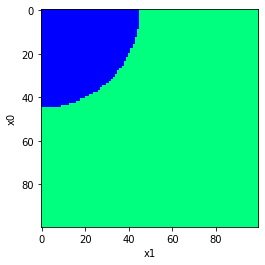

 X_1 <= -0.08000000000000002 : 4216 vs 5784
  | X_0 <= -0.07 : 1864 vs 2352
  |  | X_0 <= -0.15999999999999998 : 1486 vs 378
  |  |  | X_1 <= -0.14999999999999947 : 1241 vs 245
  |  |  |  | >> N: [0.01208703 0.98791297]
  |  |  |  | >> N: 1241
  |  |  |  | >> J: -1.00
  |  |  |  | >> Acc: 0.99
  |  |  | X_1 > -0.14999999999999947
  |  |  |  | X_0 <= -0.29000000000000004 : 154 vs 91
  |  |  |  |  | >> N: [0.03896104 0.96103896]
  |  |  |  |  | >> N: 154
  |  |  |  |  | >> J: -0.59
  |  |  |  |  | >> Acc: 0.96
  |  |  |  | X_0 > -0.29000000000000004
  |  |  |  |  | X_0 <= -0.22999999999999998 : 42 vs 49
  |  |  |  |  |  | X_1 <= -0.120000000000001 : 24 vs 18
  |  |  |  |  |  |  | X_0 <= -0.27 : 8 vs 16
  |  |  |  |  |  |  |  | >> N: [0. 1.]
  |  |  |  |  |  |  |  | >> N: 8
  |  |  |  |  |  |  |  | >> J: -0.31
  |  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  |  | X_0 > -0.27
  |  |  |  |  |  |  |  | X_1 <= -0.129999999999999 : 12 vs 4
  |  |  |  |  |  |  |  |  | X_0 <= -0.25 : 6 vs 

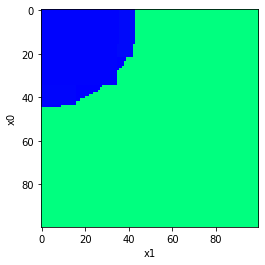

Tree with 31 leaves and depth of 14


In [11]:
tree = DecisionTree(categorical_IB(0.15), plot_optimal_split=False)
X, y = circle_data()
tree.fit(X, y)
tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
structure = tree.color(X)

### Circle, regularized with `max_depth=20`

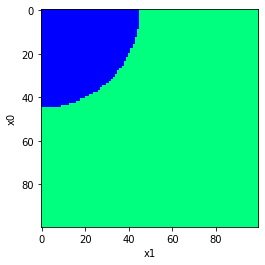

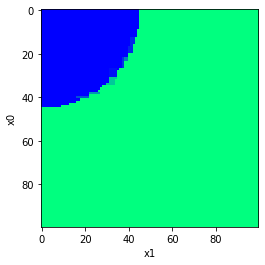

Tree with 37 leaves and depth of 9


In [12]:
tree = DecisionTree(entropy, max_depth=8)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Circle, regularized with `min_n`

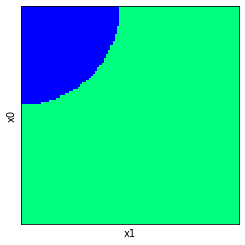

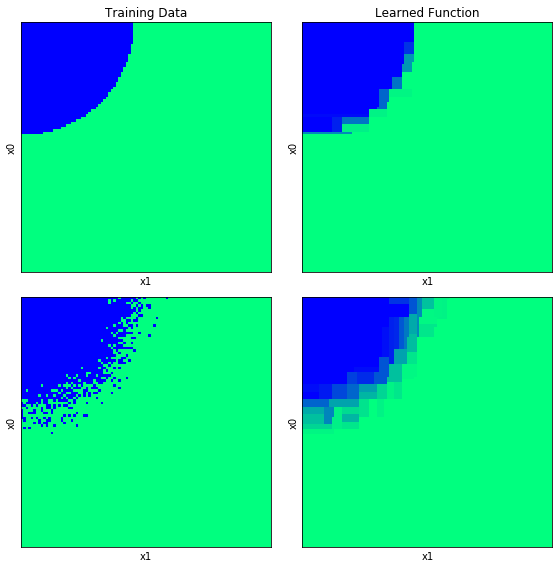

Tree with 61 leaves and depth of 11


In [33]:
tree = DecisionTree(entropy, min_n=20)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.title("Training Data")
plot_on_grid(y[:, 0], 100, show=False)
# structure = tree.color(X)
plt.subplot(222)
plt.title("Learned Function")
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100, show=False)


y_train = circle_y(X + np.random.normal(0, 0.05, size=X.shape))
tree = DecisionTree(entropy, min_n=20)
tree.fit(X, y_train)

plt.subplot(223)
plot_on_grid(y_train[:,0], 100, show=False)

plt.subplot(224)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100, show=False)
plt.tight_layout()
plt.show()

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Easy data

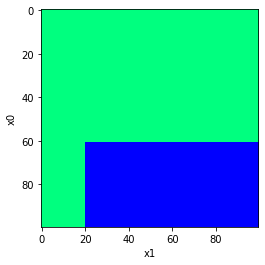

/Users/nielswarncke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nielswarncke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nielswarncke/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previ

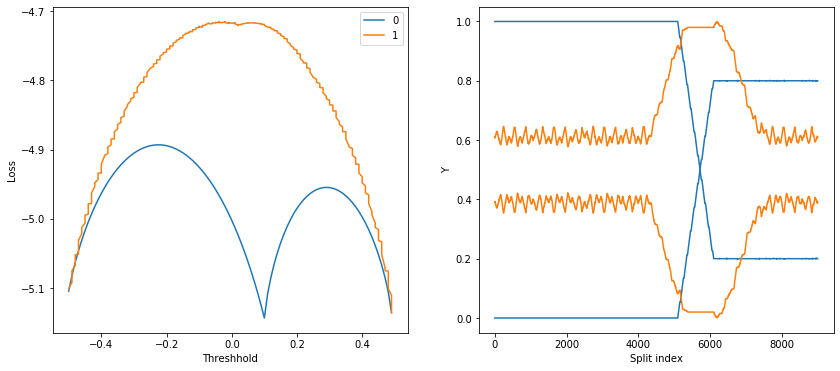

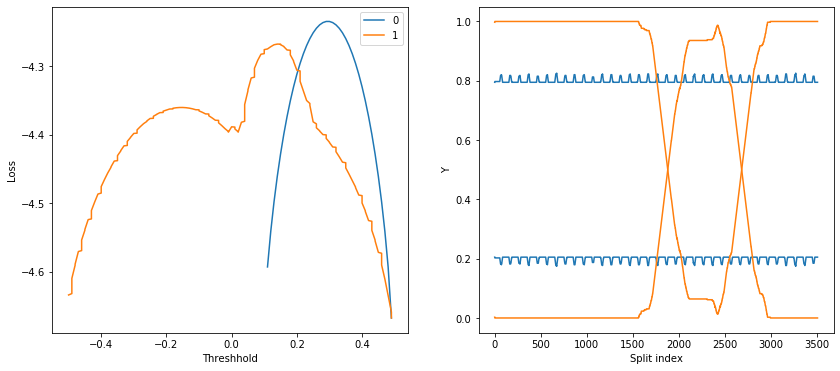

Learned function:


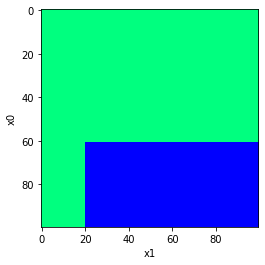

Structure of the tree


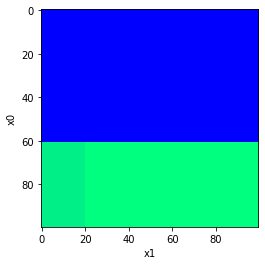

Tree with 3 leaves and depth of 3


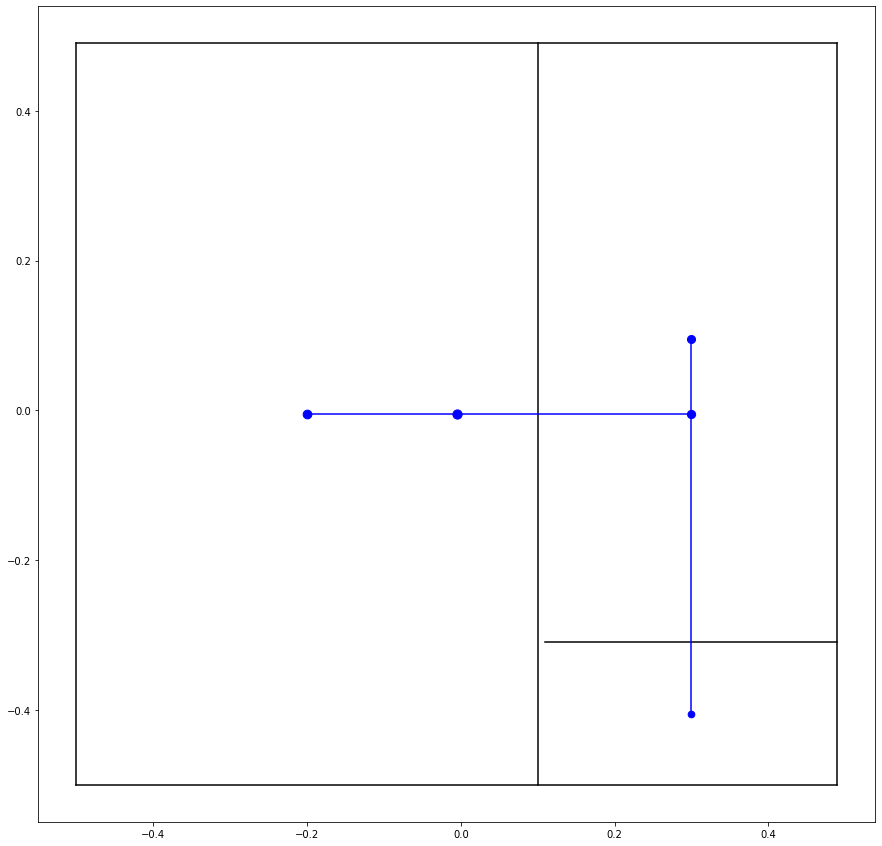

In [14]:
# y[X[:,0]<0.1,0] = 1
# y[X[:,1]<-0.3,0] = 1

tree = DecisionTree(categorical_IB(beta=0.625),
                    max_depth=2, plot_optimal_split=True)
X, y = easy_data()
tree.fit(X, y)
y_pred = tree.predict(X)
print("Learned function:")
plot_on_grid(y_pred[:, 0], 100)

print("Structure of the tree")
structure = tree.color(X)
plot_on_grid(structure, 100)
print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

tree.plot_2d_tree()

### Evaluate Probability to end up in a leave with leave size N

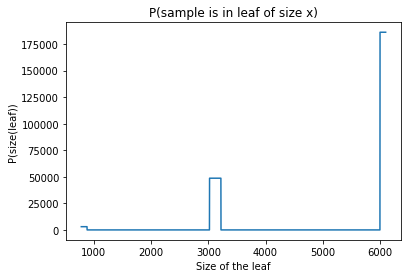

In [15]:
def fill_missing_x_with(x, y, fill=0):
    c = dict(zip(x.tolist(), y.tolist()))
    x = np.arange(x.min(), x.max()+0.5, 1)
    y = np.array([c.get(s, 0)*s for s in x])
    return x, y


leaves = tree.get_leaves()
leaf_size = [i._N for i in leaves]
sizes, counts = np.unique(leaf_size, return_counts=True)
x, p_in_leav_of_size = fill_missing_x_with(sizes, sizes*counts, fill=0)
plt.plot(x, smooth(p_in_leav_of_size, mode='same', window=200))
plt.xlabel("Size of the leaf")
plt.ylabel("P(size(leaf))")
plt.title("P(sample is in leaf of size x)")
plt.show()

## Impact of noise, add random projections

In [1]:
def uniform_label_noise(y, p_noise=0.1):
    y[:, 0] += np.round(np.random.uniform(low=0,
                                          high=0.5+p_noise/2, size=len(y)))
    y = y % 2
    y[:, 1] = 1 - y[:, 0]
    return y

X, y = circle_data()
X_train = X + np.random.normal(0, 0.025, size=X.shape)
plot_on_grid(circle_y(X_train)[:,0], 100)

tree = DecisionTree(categorical_IB(beta=0.075))
tree.fit(X_train, y)

# tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:, 0], 100)


print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
# structure = tree.color(X)
# plot_on_grid(structure, 100)

NameError: name 'circle_data' is not defined

## Utils

# Presentation